# TVB-NEST: Bridging multiscale activity by co-simulation

## Step-by-step learn how to perform a co-simulation embedding spiking neural networks into large-scale brain networks using TVB.

## tvb-multiscale toolbox:

### https://github.com/the-virtual-brain/tvb-multiscale

For questions use the git issue tracker, or write an e-mail to me: dionysios.perdikis@charite.de

# TVB simulation 

## Thalamocortical Wilson - Cowan like TVB mean field model [4]

For every cortical region $n\prime$, there is a specific thalamic nucleus $m\prime$ connected to it.
Such specific thalamic nuclei connect potentially, besides their cortical pair, to all other subcortical nodes of the connectome $s\prime$, including the nonspecific thalamus.

For every (sub)cortical region node $n\prime$ ($s\prime$) modelled as a mean-field node in TVB:

- Population activity dynamics of 1 excitatory and 1 inhibitory cortical populations:

\begin{align}
\dot{E}_{n\prime} = \dfrac{1}{\tau_e} (&- E_{n\prime} + w_{ee} \mathcal{Sigm}(E_{n\prime}  ) + w_{ie} \mathcal{Sigm}(I_{n\prime}) \\
                    & + G_{n\prime}\sum_{n\prime _j}\{{w_{n\prime n\prime _j}\mathcal{Sigm}(E_{n\prime _j}(t - \tau_{n\prime n\prime _j}))}\} \\
                    & + w_{se}\sum_{m\prime _j}\{{w_{n\prime m\prime _j}\mathcal{Sigm}(E_{m\prime _j}(t - \tau_{n\prime m\prime _j}))}\} \\
                    & + I_e + Ie_{n\prime}(t)) \\
\end{align}

\begin{align}
\dot{I}_{n\prime} = \dfrac{1}{\tau_i} (&- I_{n\prime} + w_{ei} \mathcal{Sigm}(E_{n\prime}) + w_{ii} \mathcal{Sigm}(I_{n\prime}) \\
                               & + w_{si} \sum_{m\prime _j}\{{w_{n\prime m\prime _j}\mathcal{Sigm}(E_{m\prime _j}(t - \tau_{n\prime m\prime _j}))}\} \\
                               & + I_i
                                )
\end{align}                  

For every specific thalamic nucleus node $m\prime$ modelled as a mean-field node in TVB:

- Population activity dynamics of 1 excitatory relay and 1 inhibitory reticular thalamic nuclei:

\begin{align}
\dot{E}_{m\prime} = \dfrac{1}{\tau_s} ( & - E_{m\prime}  
                                + w_{rs} \mathcal{Sigm}(I_{m\prime}(t - \tau_{tt})) \\
                                 & +  w_{es} \sum_{n\prime \neq s\prime _j}\{{w_{m\prime n\prime _j}\mathcal{Sigm} (E_{n\prime _j}(t - \tau_{m\prime n\prime _j}))}\} \\
                                 & +  G_{s\prime} \sum_{s\prime _j}\{{w_{m\prime s\prime _j}\mathcal{Sigm} (E_{s\prime _j}(t - \tau_{m\prime s\prime _j}))}\} \\
                                & + I_s + Is_{m\prime}(t) )                   
\end{align}

\begin{align}
\dot{I}_{m\prime} = \dfrac{1}{\tau_r} (& - I_{m\prime}  
                                + w_{sr} \mathcal{Sigm}(E_{m\prime}(t - \tau_{tt})) \\
                               & + w_{er} \sum_{n\prime \neq s\prime _j}\{{w_{m\prime n\prime _j}\mathcal{Sigm} (E_{n\prime _j}(t - \tau_{m\prime n\prime _j}))}\} \\
                               & + I_r )
\end{align}                   

                                
                               
For BOLD, we record the postsynaptic firing rate activity of $E$, as an extra, non-integrated state variable $A$:

For (sub)cortical nodes:

\begin{align}
{A}_{n\prime} &= w_{ee} \mathcal{Sigm}(E_{n\prime}  ) + w_{ie} \mathcal{Sigm}(I_{n\prime}) \\
              & + G_{n\prime}*\sum_{n\prime _j}\{{w_{n\prime n\prime _j}\mathcal{Sigm}(E_{n\prime _j}(t - \tau_{n\prime n\prime _j}))}\} \\
                    & + w_{se} \sum_{m\prime _j}\{{w_{n\prime m\prime _j}\mathcal{Sigm}(E_{m\prime _j}(t - \tau_{n\prime m\prime _j}))}\}
\end{align}

For specific thalamic nuclei nodes:

\begin{align}
{A}_{m\prime} & = w_{rs} \mathcal{Sigm}(I_{m\prime}(t - \tau_{tt})) \\
              & +  w_{es} \sum_{n\prime \neq s\prime _j}\{{w_{m\prime n\prime _j}\mathcal{Sigm} (E_{n\prime _j}(t - \tau_{n\prime n\prime _j}))}\} \\
              & +  G_{s\prime} \sum_{s\prime _j}\{{w_{m\prime s\prime _j}\mathcal{Sigm} (E_{s\prime _j}(t - \tau_{m\prime s\prime _j}))}\}
\end{align}

                
In all cases, we use the same sigmoidal activation function:

$ Sigm(x) = \frac{1}{1+e^{-\beta(x - \sigma)}} $

Note that the global coupling $G$ does NOT scale any of the connections that involve the specific thalamic nuclei, including those to/from other subcortical structures, besides the single connections with the specific cortical node, each nucleus couples to.


# WORKFLOW:

In [1]:
import os
from collections import OrderedDict
import time
import numpy as np

from tvb.basic.profile import TvbProfile
TvbProfile.set_profile(TvbProfile.LIBRARY_PROFILE)

from tvb_multiscale.tvb_nest.config import *

# ----------- Simulation options ----------------
TEST = True
G = 50.0  # in Griffiths et al paper = 5.0
STIMULUS = True
DEMO = False  # To simulate disconnected Griffiths' et al like thalamocortical nodes for alpha + gamma bands
# WHOLE_BRAIN = False
THAL_CRTX_FIX = "wd" # "wd", "w", "d" or False, in order to fix values of thalamocortical Weights, Delays, or both, to the Griffiths et al values, or not
BRAIN_CONNECTIONS_TO_SCALE = [] # e.g., [["Region 1", ["Region 2", "Region 3"], scaling_factor]]
# -----------------------------------------------

BRAIN_CONN_FILE = "Connectivity_SummedSubcortical_Thals.h5" # "Connectivity_SummedSubcortical.h5", Connectivity_res100_summ49regions_IOsplit.h5"
MAJOR_STRUCTS_LABELS_FILE = "major_structs_labels_SummedSubcortical_Thals.npy"
VOXEL_COUNT_FILE = "voxel_count_SummedSubcortical_Thals.npy"
INDS_FILE = "inds_SummedSubcortical_Thals.npy"

work_path = os.getcwd()
data_path = os.path.join(work_path.split("tvb_nest")[0], "data", "cerebellum")
tvb_conn_filepath = os.path.join(data_path, BRAIN_CONN_FILE)
outputs_path = os.path.join(work_path, "outputs/cereb_wilson_cowan")
outputs_path += '_G%g' % G
outputs_path += "_TVBonly"
outputs_path += "_%s" % (BRAIN_CONN_FILE.split("Connectivity_")[-1].split(".h5")[0])
if THAL_CRTX_FIX:
    outputs_path += "THAL_CRTX_FIX%s" % THAL_CRTX_FIX.upper()
if STIMULUS:
    outputs_path += "_Stim"
if DEMO:
    outputs_path += "_demo"
print("Outputs' path: %s" % outputs_path)

config = Config(output_base=outputs_path)
config.figures.SHOW_FLAG = True 
config.figures.SAVE_FLAG = True
config.figures.FIG_FORMAT = 'png'
config.figures.DEFAULT_SIZE= config.figures.NOTEBOOK_SIZE
FIGSIZE = config.figures.DEFAULT_SIZE

NOISE = 1e-6 # config.DEFAULT_NSIG = 0.001


from tvb_multiscale.core.plot.plotter import Plotter
plotter = Plotter(config.figures)

# For interactive plotting:
# %matplotlib notebook  

# Otherwise:
%matplotlib inline


2021-12-08 18:16:16,770 - INFO - tvb_multiscale.tvb_nest.config - Loading a NEST instance...
2021-12-08 18:16:16,770 - INFO - tvb_multiscale.tvb_nest.config - Loading a NEST instance...
2021-12-08 18:16:16,774 - INFO - tvb_multiscale.tvb_nest.config - NEST_INSTALL_DIR: /home/docker/env/neurosci/nest_build
2021-12-08 18:16:16,774 - INFO - tvb_multiscale.tvb_nest.config - NEST_INSTALL_DIR: /home/docker/env/neurosci/nest_build
2021-12-08 18:16:16,777 - INFO - tvb_multiscale.tvb_nest.config - NEST_DATA_DIR: /home/docker/env/neurosci/nest_build/share/nest
2021-12-08 18:16:16,777 - INFO - tvb_multiscale.tvb_nest.config - NEST_DATA_DIR: /home/docker/env/neurosci/nest_build/share/nest
2021-12-08 18:16:16,780 - INFO - tvb_multiscale.tvb_nest.config - NEST_DOC_DIR: /home/docker/env/neurosci/nest_build/share/doc/nest
2021-12-08 18:16:16,780 - INFO - tvb_multiscale.tvb_nest.config - NEST_DOC_DIR: /home/docker/env/neurosci/nest_build/share/doc/nest
2021-12-08 18:16:16,784 - INFO - tvb_multiscale.tv

Outputs' path: /home/docker/packages/tvb-multiscale/examples/tvb_nest/notebooks/cerebellum/outputs/cereb_wilson_cowan_G50_TVBonly_SummedSubcortical_ThalsTHAL_CRTX_FIXWD_Stim



## 1. Load structural data <br> (minimally a TVB connectivity)  <br> & prepare TVB simulator  <br> (region mean field model, integrator, monitors etc)

In [2]:
dt = config.DEFAULT_DT  # =0.1

In [3]:
import h5py
f = h5py.File(tvb_conn_filepath)
centres=np.array(f["centres"][()]) # hemispheres=np.array(f["hemispheres"][()]), 
region_labels=np.array(f["region_labels"][()]).astype("<U128")
weights=np.array(f["weights"][()])
tract_lengths=np.array(f["tract_lengths"][()]) 
f.close()

major_structs_labels = np.load(os.path.join(data_path, MAJOR_STRUCTS_LABELS_FILE))
voxel_count = np.load(os.path.join(data_path, VOXEL_COUNT_FILE))
inds = np.load(os.path.join(data_path, INDS_FILE), allow_pickle=True).item()
print(inds)

{'crtx': array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164]), 'm1': array([  1, 123]), 's1brl': array([  4, 126]), 'supcol': array([ 95,  95, 217, 217]), 'facial': array([102, 224]), 'trigeminal': array([101, 223]), 'ponssens_trigeminal': array([ 97, 219]), 'ponssens': array([ 96,  97, 218, 219]), 'ponsmotor': array([ 98, 220]), 'thal': array([ 92, 214]), 'thalspec': array([ 43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
        56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,
        69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  

In [4]:
# Find thalamic index:
inds["subcrtx"] = np.arange(len(region_labels)).astype('i')
inds["subcrtx"] = np.delete(inds["subcrtx"], inds["crtx"])
is_subcortical = np.array([False] * region_labels.shape[0]).astype("bool")
is_subcortical[inds["subcrtx"]] = True
is_cortical = np.array([False] * region_labels.shape[0]).astype("bool")
is_cortical[inds["crtx"]] = True
is_thalamic = np.array([False] * region_labels.shape[0]).astype("bool")
is_thalamic[inds["thalspec"]] = True
is_subcortical_not_thalspec = np.logical_and(is_subcortical, np.logical_not(is_thalamic))
inds["subcrtx_not_thalspec"] = np.where(is_subcortical_not_thalspec)[0]

In [5]:
from tvb.datatypes.connectivity import Connectivity

# Load connectivity
# config.DEFAULT_CONNECTIVITY_ZIP = "/home/docker/packages/tvb_data/tvb_data/mouse/allen_2mm/ConnectivityAllen2mm.zip"                                  
# connectivity = Connectivity.from_file(config.DEFAULT_CONNECTIVITY_ZIP)

connectivity = Connectivity(centres=centres, region_labels=region_labels, 
                            weights=weights, tract_lengths=tract_lengths)

# Selectively scale up some connections, if required:
for reg1, reg2, sc in BRAIN_CONNECTIONS_TO_SCALE:
    iR1 = np.where([reg in reg1 for reg in connectivity.region_labels])[0]
    iR2 = np.where([reg in reg2 for reg in connectivity.region_labels])[0]
    connectivity.weights[iR1, iR2] *= sc
    
# Normalize connectivity weights
connectivity.weights[np.isnan(connectivity.weights)] = 0.0
connectivity.weights = connectivity.scaled_weights(mode="region")
connectivity.weights /= np.percentile(connectivity.weights, 99)
# connectivity.weights[connectivity.weights > 1.0] = 1.0

connectivity.tract_lengths = np.maximum(connectivity.speed * dt, 
                                        connectivity.tract_lengths)

connectivity.configure()

# Plot TVB connectome:
# plotter.plot_tvb_connectivity(connectivity);


In [6]:

# -----------------------------------Build cosimulator manually--------------------------------
from tvb_multiscale.core.tvb.cosimulator.cosimulator_serial import CoSimulatorSerial

simulator = CoSimulatorSerial()

simulator.connectivity = connectivity



In [7]:
from tvb_multiscale.core.tvb.cosimulator.models.wc_thalamocortical_cereb import WilsonCowanThalamoCortical
from examples.tvb_nest.notebooks.cerebellum.utils import print_conn


dummy_shape = (simulator.connectivity.number_of_regions,)

# G normalized by the number of regions as in Griffiths et al paper
model_params = {"G": np.array([G])/(simulator.connectivity.number_of_regions - inds['thalspec'].size)}
if DEMO:
    model_params.update({'G': model_params["G"],
                         'I_o': np.array([0.0]),
                         'w_ee': np.array([1.4]), 
                         'w_ei': np.array([1.4]), 
                         'w_ie': np.array([-3.0]),
                         'w_se': np.array([1.6]),
                         'tau_e': np.array([10.0/0.9]), 
                         'tau_i': np.array([10.0/0.9]),
                         'tau_s': np.array([10.0/0.25]), 
                         'tau_r': np.array([10.0/0.25])
                        })
 
if STIMULUS:
    # Stimuli:
    A_st = np.zeros(dummy_shape).astype("f")
    f_st = np.zeros(dummy_shape).astype("f")
    if TEST:
        # M1:
        A_st[[44, 166]] = 1.0
        f_st[[44, 166]] = 6.0 # Hz
    else:
        # Sensory to Medulla SPV
        A_st[inds["trigeminal"]] = 1.0
        f_st[inds["trigeminal"]] = 6.0 # Hz
        # Motor to Facial nucleus
        A_st[inds["facial"]] = 1.0
        f_st[inds["facial"]] = 6.0 # Hz
    model_params.update({"A_st": A_st, "f_st": f_st})

simulator.model = WilsonCowanThalamoCortical(is_cortical=is_cortical[:, np.newaxis], 
                                             is_thalamic=is_thalamic[:, np.newaxis],
                                             **model_params)
simulator.model.dt = dt
simulator.model.test_mode = TEST

# # Specific thalamic relay -> nonspecific subcortical structures connections' weights:
# w_se = simulator.model.w_se * np.ones(dummy_shape)
# w_se[inds['subcrtx']] = 0.0*simulator.model.G[0]  # we have zeroed for testing!
# simulator.model.w_se = w_se
# w_si = simulator.model.w_si * np.ones(dummy_shape)
# w_si[inds['subcrtx']] = 0.0
# simulator.model.w_si = w_si
# #  Nonspecific subcortical -> specific thalamic relay and reticular structures connections' weights:
# simulator.model.G = simulator.model.G * np.ones(dummy_shape)
# simulator.model.G[inds["thalspec"]] = 0.0
# The following seems redundant given the above zeroings!:
# simulator.connectivity.weights[inds["thalspec"][:, None], inds["subcrtx_not_thalspec"][None, :]] = 0.0
# simulator.connectivity.weights[inds["subcrtx_not_thalspec"][:, None], inds["thalspec"][None, :]] = 0.0

# # Homogenize crtx <-> subcrtx connnectivity
# simulator.connectivity.weights[inds["crtx"][:, None], inds["subcrtx_not_thalspec"][None, :]] = 0.0 # 0.02
# # simulator.connectivity.weights[inds["subcrtx_not_thalspec"][:, None], inds["crtx"][None, :]] = 0.0 # 0.02

# Variability to thalamocortical connections:
if THAL_CRTX_FIX:
    
    if "w" in THAL_CRTX_FIX:
        # Fix structural connectivity (specific) thalamo-cortical weights to 1, 
        # such that all thalamo-cortical weights are equal to the parameters 
        # w_er, w_es, w_se, w_si
        simulator.connectivity.weights[inds["crtx"], inds["thalspec"]] = 1.0
        simulator.connectivity.weights[inds["thalspec"], inds["crtx"]] = 1.0
        
    if "d" in THAL_CRTX_FIX:
        # Fix structural connectivity (specific) thalamo-cortical tracts length to a value, 
        # such that all thalamo-cortical delays are equal to the parameter tau_ct,
        # given connectivity's speed.
        ct_lengths = simulator.connectivity.speed * \
                     simulator.model.tau_ct * np.ones((simulator.connectivity.number_of_regions, ))[inds["crtx"]]
        simulator.connectivity.tract_lengths[inds["crtx"], inds["thalspec"]] = ct_lengths
        simulator.connectivity.tract_lengths[inds["thalspec"], inds["crtx"]] = ct_lengths

    simulator.connectivity.configure()
   
        

In [8]:
from tvb_multiscale.core.tvb.cosimulator.models.wc_thalamocortical_cereb import SigmoidalPreThalamoCortical
from tvb.simulator.integrators import EulerStochastic, HeunStochastic
from tvb.simulator.monitors import Raw, Bold

simulator.coupling = SigmoidalPreThalamoCortical(
                        is_thalamic=is_thalamic,
                        is_subcortical=is_subcortical,
                        sigma=np.array([1.0]),
                        midpoint=simulator.model.sigma, 
                        cmin=np.array([0.0]), 
                        cmax=np.array([1.0]), 
                        a=simulator.model.beta) 

simulator.integrator = HeunStochastic()  #EulerStochastic() # HeunStochastic()  #
simulator.integrator.dt = dt
simulator.integrator.noise.nsig = np.array([NOISE] * (simulator.model.nvar-1) + [0.0]) # config.DEFAULT_NSIG = 0.001

simulator.initial_conditions = np.zeros((1000, simulator.model.nvar, connectivity.number_of_regions, 1))

mon_raw = Raw(period=1.0)  # ms
bold = Bold(period=128.0, variables_of_interest=np.array([2]))  # !!! Set a proper (1-2 sec??) TR time in ms !!!
simulator.monitors = (mon_raw, bold)
simulator.configure()

simulator.integrate_next_step = simulator.integrator.integrate_with_update

## 4. Configure simulator, simulate, gather results

In [9]:
# Simulate!

# Set the simulation time:
simulation_length =  1124.0  # for reasonable resting state, use about 1 min = 60 sec = 60000.0 ms + transient
transient = 100.0 # 0.1 * simulation_length    
simulator.simulation_length = simulation_length

tic = time.time()
results = simulator.run()
print("\nSimulated in %f secs!" % (time.time() - tic))



Simulated in 144.990592 secs!


## 5. Plot results and write them to HDF5 files

In [10]:
from scipy.io import savemat
# set to False for faster plotting of only mean field variables and dates, apart from spikes" rasters:
plot_per_neuron = False  
MAX_VARS_IN_COLS = 3
MAX_REGIONS_IN_ROWS = 10
MIN_REGIONS_FOR_RASTER_PLOT = 9
# from examples.plot_write_results import plot_write_results
# plot_write_results(results, simulator, populations=populations, 
#                    transient=transient, tvb_state_variable_type_label="State Variables", 
#                    tvb_state_variables_labels=simulator.model.variables_of_interest, 
#                    plot_per_neuron=plot_per_neuron, plotter=plotter, config=config)

In [11]:
# If you want to see what the function above does, take the steps, one by one
try:
    # We need framework_tvb for writing and reading from HDF5 files
    from tvb_multiscale.tvb.core.io.h5_writer import H5Writer
    writer = H5Writer()
except:
    writer = False
    
from tvb.contrib.scripts.datatypes.time_series import TimeSeriesRegion
from tvb.contrib.scripts.datatypes.time_series_xarray import TimeSeriesRegion as TimeSeriesXarray

# Put the results in a Timeseries instance
from tvb.contrib.scripts.datatypes.time_series import TimeSeriesRegion

source_ts = None
bold_ts = None

if results is not None:
    source_ts = TimeSeriesXarray(  # substitute with TimeSeriesRegion fot TVB like functionality
            data=results[0][1], time=results[0][0],
            connectivity=simulator.connectivity,
            labels_ordering=["Time", "State Variable", "Region", "Neurons"],
            labels_dimensions={"State Variable": list(simulator.model.variables_of_interest),
                               "Region": simulator.connectivity.region_labels.tolist()},
            sample_period=simulator.integrator.dt)
    source_ts.configure()

    t = source_ts.time

    # Write to file
    if writer:
        writer.write_tvb_to_h5(TimeSeriesRegion().from_xarray_DataArray(source_ts._data,
                                                                        connectivity=source_ts.connectivity),
                               os.path.join(config.out.FOLDER_RES, source_ts.title)+".h5")
    print("Raw ts:\n%s" % str(source_ts))
    
    if len(results) > 1:
        bold_ts = TimeSeriesXarray(  # substitute with TimeSeriesRegion fot TVB like functionality
                data=results[1][1], time=results[1][0],
                connectivity=simulator.connectivity,
                labels_ordering=["Time", "State Variable", "Region", "Neurons"],
                labels_dimensions={"State Variable": ["BOLD"],
                                   "Region": simulator.connectivity.region_labels.tolist()})
        bold_ts.configure()

        bold_t = source_ts.time

        # Write to file
        if writer:
            writer.write_tvb_to_h5(TimeSeriesRegion().from_xarray_DataArray(bold_ts._data,
                                                                            connectivity=bold_ts.connectivity),
                                   os.path.join(config.out.FOLDER_RES, bold_ts.title)+".h5")
        print("BOLD ts:\n%s" % str(bold_ts))
    

Raw ts:
TimeSeriesRegion (
  Dimensions .......... ['Time', 'State Variable', 'Region', 'Neurons']
  Length .............. 11240
  Region Mapping ...... None
  Region Mapping Volume  None
  Sample period ....... 0.1
  Source Connectivity . Connectivity gid: 586e13b4-9385-4370-b022-ad0f472a667d
  Time units .......... ms
  Time-series name .... Region Time Series
  Time-series type .... TimeSeriesRegion
  [min, median, max] .. [-1.27273, 0.452627, 241.536]
  dtype ............... float64
  shape ............... (11240, 3, 244, 1)
)
BOLD ts:
TimeSeriesRegion (
  Dimensions .......... ['Time', 'State Variable', 'Region', 'Neurons']
  Length .............. 9
  Region Mapping ...... None
  Region Mapping Volume  None
  Sample period ....... 128.0
  Source Connectivity . Connectivity gid: 586e13b4-9385-4370-b022-ad0f472a667d
  Time units .......... ms
  Time-series name .... Region Time Series
  Time-series type .... TimeSeriesRegion
  [min, median, max] .. [-0.759256, 0.263502, 669.824]
  d

/home/docker/packages/tvb-root/tvb_contrib/tvb/contrib/scripts/datatypes/time_series_xarray.py:868: MatplotlibDeprecationWarning: 
The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.
  pyplot.gcf().canvas.set_window_title(figname)


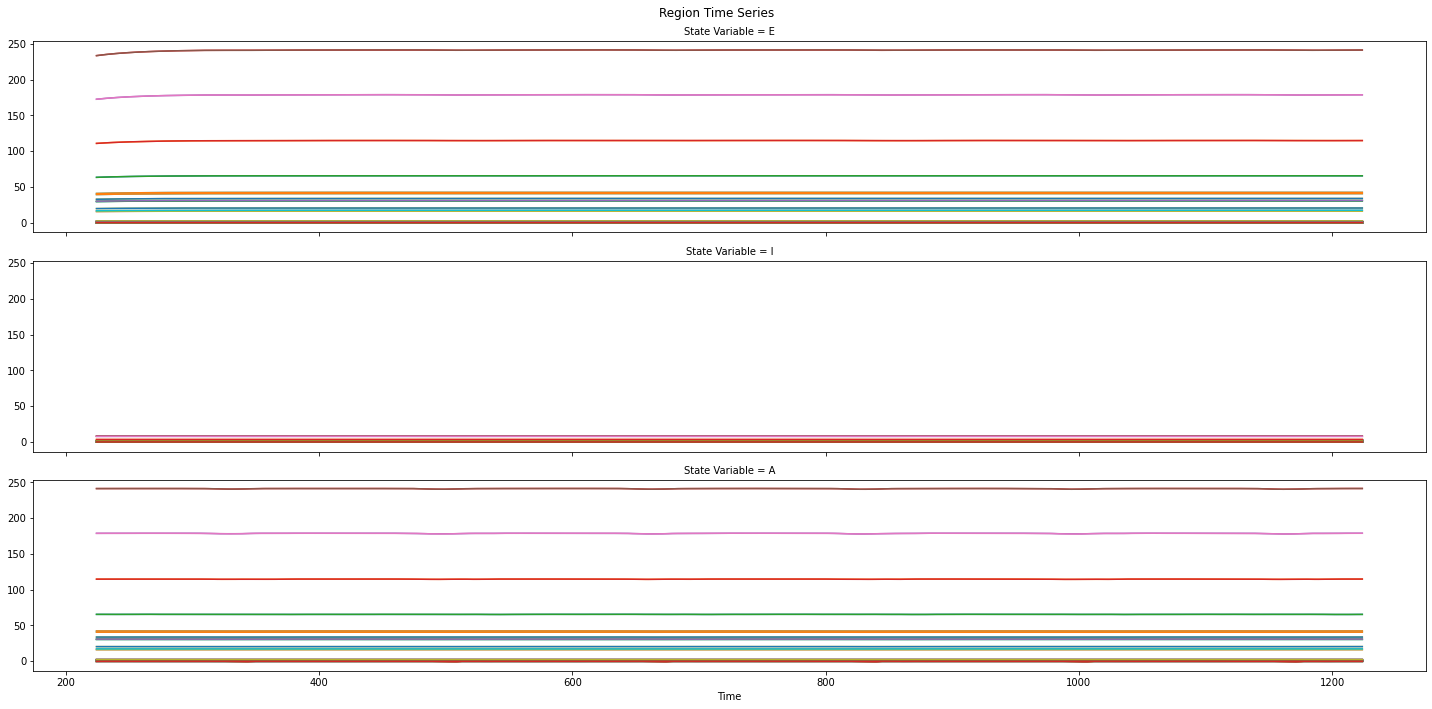

In [12]:
# Plot TVB time series
if source_ts is not None:
    source_ts[-10000:].plot_timeseries(plotter_config=plotter.config, 
                          hue="Region" if source_ts.shape[2] > MAX_REGIONS_IN_ROWS else None, 
                          per_variable=source_ts.shape[1] > MAX_VARS_IN_COLS, 
                          figsize=FIGSIZE);

2021-12-08 18:18:48,791 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!


/home/docker/packages/tvb-root/tvb_contrib/tvb/contrib/scripts/datatypes/time_series_xarray.py:868: MatplotlibDeprecationWarning: 
The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.
  pyplot.gcf().canvas.set_window_title(figname)


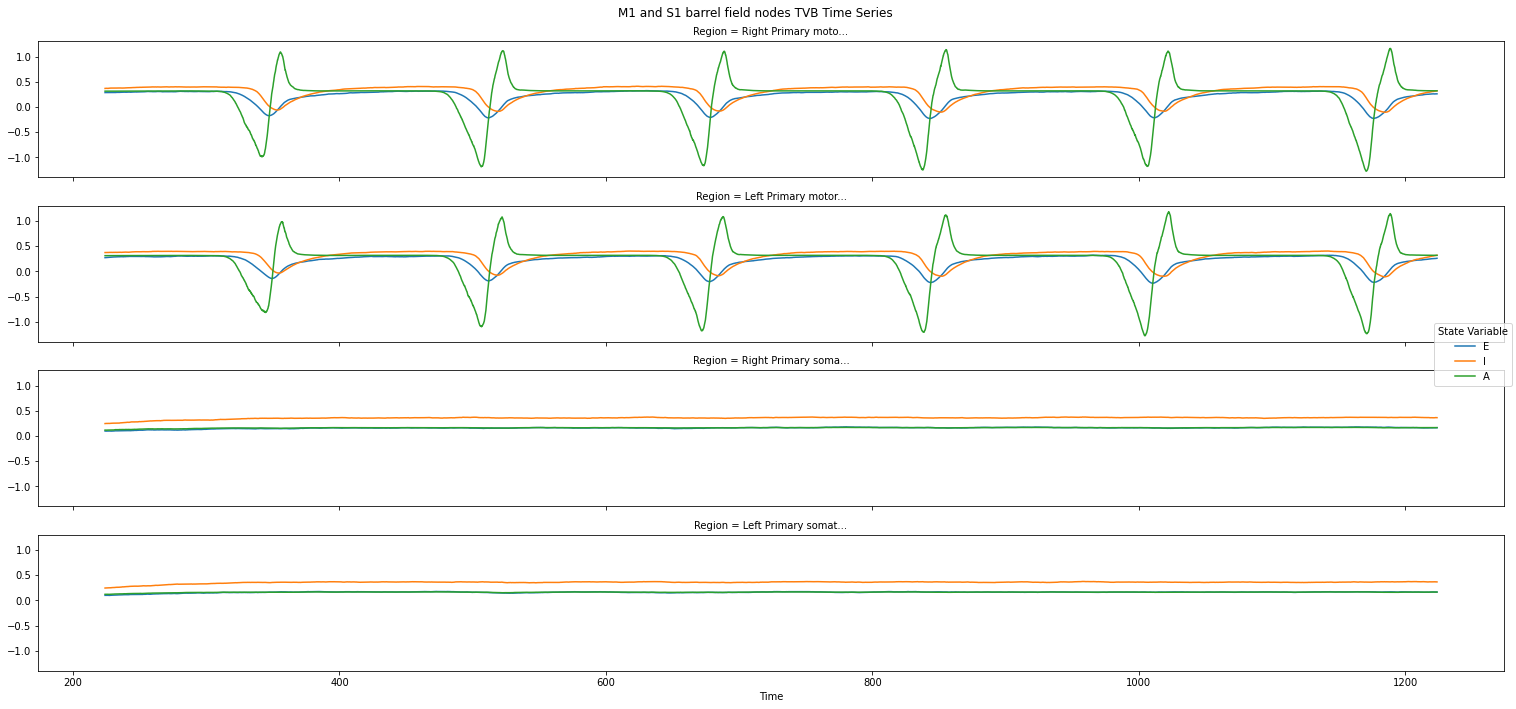

In [13]:
# Focus on the m1 and s1 barrel field nodes: 
if source_ts is not None:
    source_ts_m1s1brl = source_ts[-10000:, :, inds["m1s1brl"]]
    source_ts_m1s1brl.plot_timeseries(plotter_config=plotter.config, 
                                   hue="Region" if source_ts_m1s1brl.shape[2] > MAX_REGIONS_IN_ROWS else None, 
                                   per_variable=source_ts_m1s1brl.shape[1] > MAX_VARS_IN_COLS, 
                                   figsize=FIGSIZE, figname="M1 and S1 barrel field nodes TVB Time Series");

In [14]:
# Focus on the m1 and s1 barrel field nodes: raster plot
if source_ts is not None and source_ts_m1s1brl.number_of_labels > MIN_REGIONS_FOR_RASTER_PLOT:
    source_ts_m1s1brl.plot_raster(plotter_config=plotter.config, 
                                  per_variable=source_ts_m1s1brl.shape[1] > MAX_VARS_IN_COLS,
                                  figsize=FIGSIZE, figname="M1 and S1 barrel field nodes TVB Time Series Raster");

2021-12-08 18:18:49,921 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!


/home/docker/packages/tvb-root/tvb_contrib/tvb/contrib/scripts/datatypes/time_series_xarray.py:868: MatplotlibDeprecationWarning: 
The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.
  pyplot.gcf().canvas.set_window_title(figname)


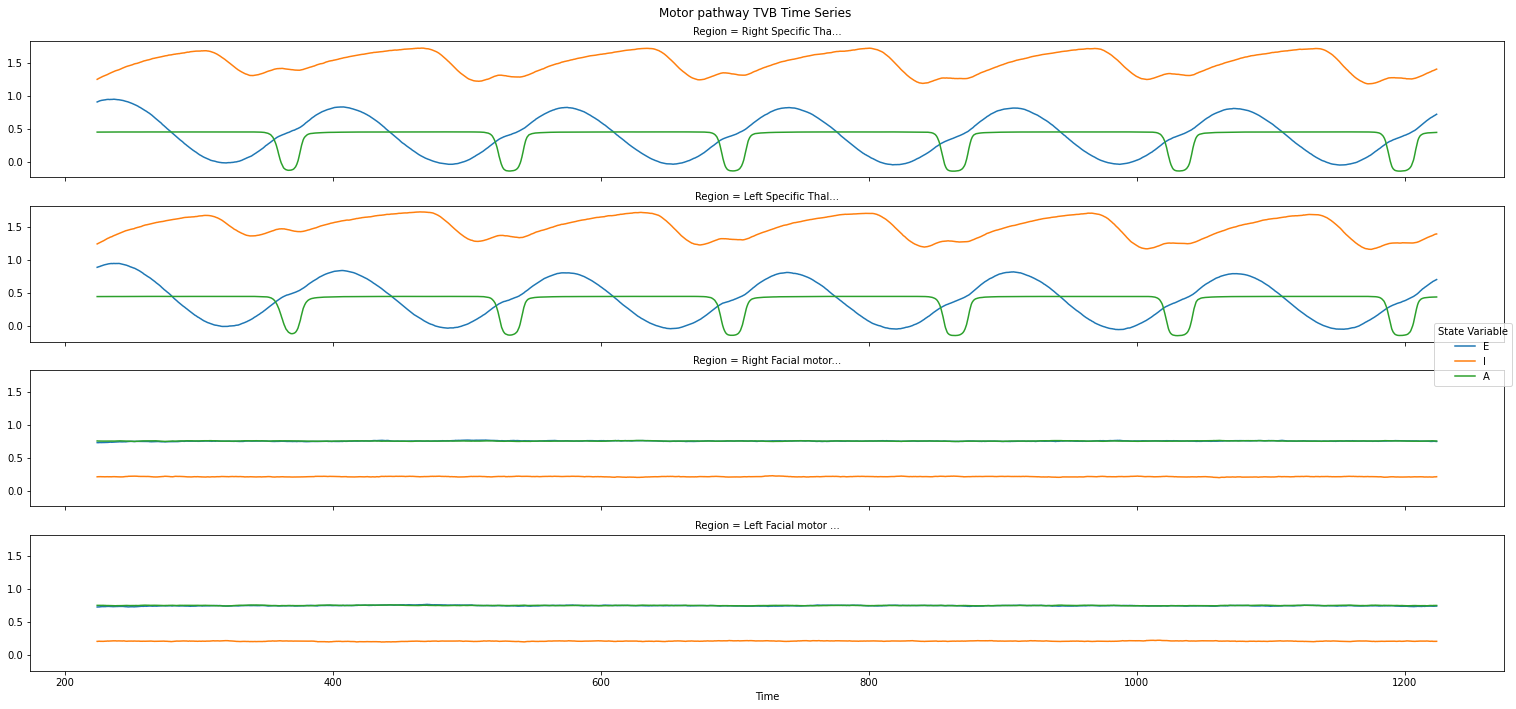

In [15]:
# Focus on the the motor pathway: 
if source_ts is not None:
    source_ts_motor = source_ts[-10000:, :, inds["motor"]]
    source_ts_motor.plot_timeseries(plotter_config=plotter.config, 
                                   hue="Region" if source_ts_motor.shape[2] > MAX_REGIONS_IN_ROWS else None, 
                                   per_variable=source_ts_motor.shape[1] > MAX_VARS_IN_COLS, 
                                   figsize=FIGSIZE, figname="Motor pathway TVB Time Series");

In [16]:
# Focus on the motor pathway: raster plot
if source_ts_motor is not None and source_ts_motor.number_of_labels > MIN_REGIONS_FOR_RASTER_PLOT:
    source_ts_motor.plot_raster(plotter_config=plotter.config, 
                                  per_variable=source_ts_motor.shape[1] > MAX_VARS_IN_COLS,
                                  figsize=FIGSIZE, figname="Motor pathway TVB Time Series Raster");

2021-12-08 18:18:51,227 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!


/home/docker/packages/tvb-root/tvb_contrib/tvb/contrib/scripts/datatypes/time_series_xarray.py:868: MatplotlibDeprecationWarning: 
The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.
  pyplot.gcf().canvas.set_window_title(figname)


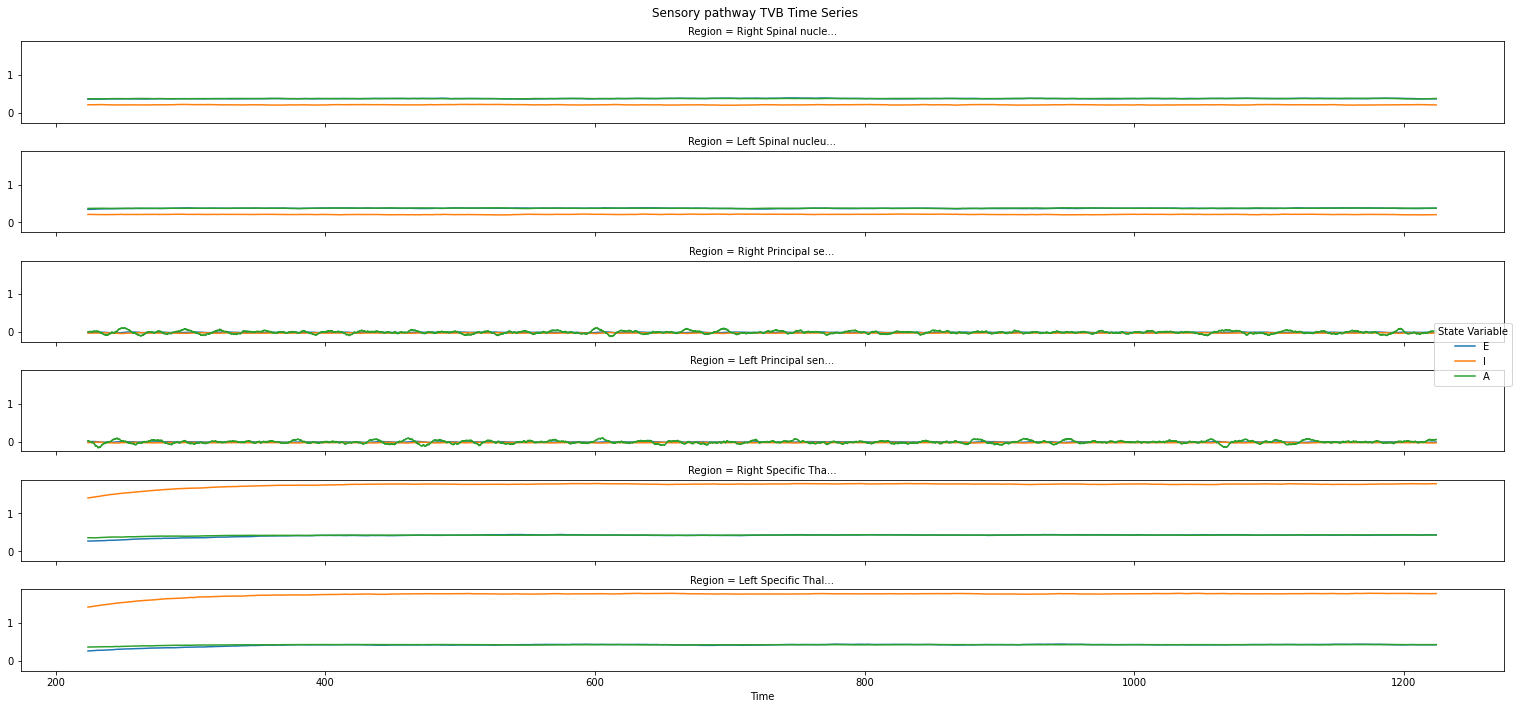

In [17]:
# Focus on the sensory pathway: 
if source_ts is not None:
    source_ts_sens = source_ts[-10000:, :, inds["sens"]]
    source_ts_sens.plot_timeseries(plotter_config=plotter.config, 
                                   hue="Region" if source_ts_sens.shape[2] > MAX_REGIONS_IN_ROWS else None, 
                                   per_variable=source_ts_sens.shape[1] > MAX_VARS_IN_COLS, 
                                   figsize=FIGSIZE, figname="Sensory pathway TVB Time Series");

In [18]:
# Focus on the sensory pathway: raster plot
if source_ts is not None and source_ts_sens.number_of_labels > MIN_REGIONS_FOR_RASTER_PLOT:
    source_ts_sens.plot_raster(plotter_config=plotter.config, 
                               per_variable=source_ts_sens.shape[1] > MAX_VARS_IN_COLS,
                               figsize=FIGSIZE, figname="Sensory pathway TVB Time Series Raster");

/home/docker/packages/tvb-root/tvb_contrib/tvb/contrib/scripts/datatypes/time_series_xarray.py:868: MatplotlibDeprecationWarning: 
The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.
  pyplot.gcf().canvas.set_window_title(figname)


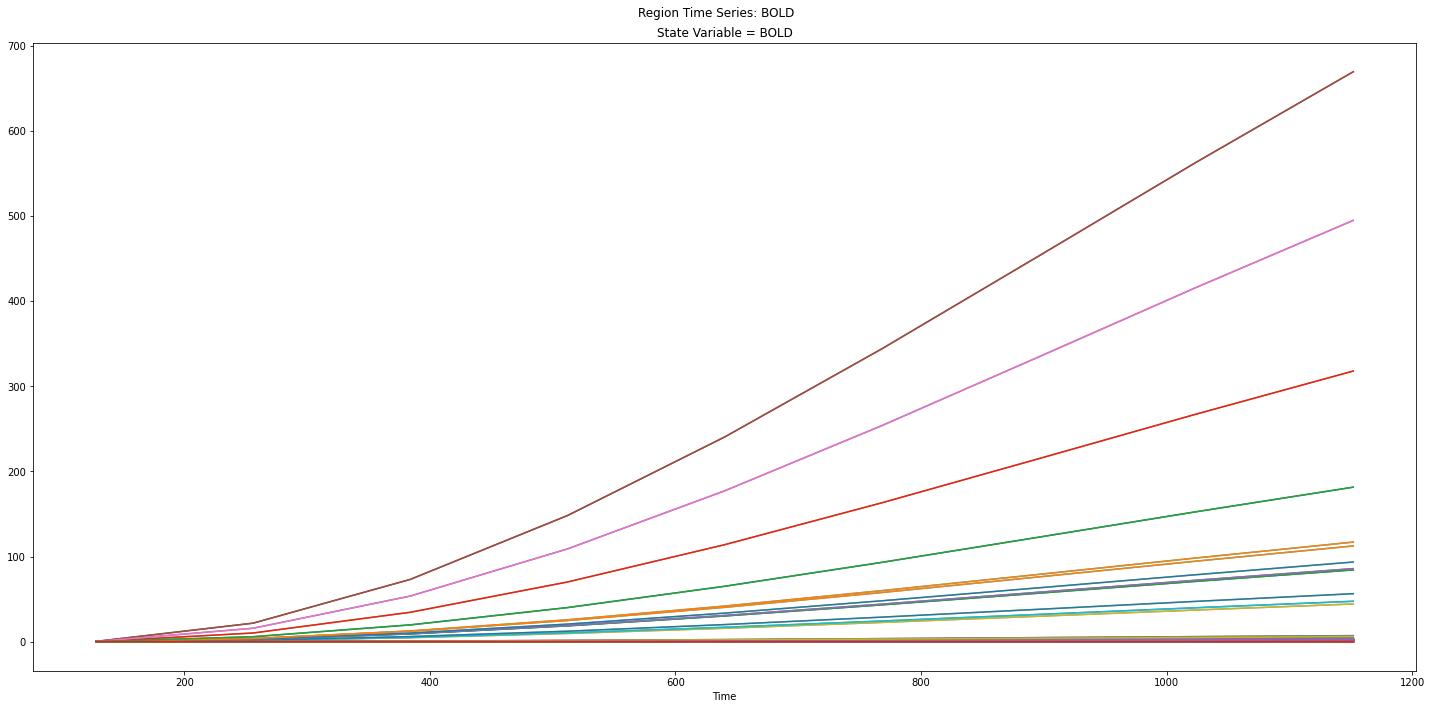

In [19]:
# bold_ts TVB time series
if bold_ts is not None:
    bold_ts.plot_timeseries(plotter_config=plotter.config, 
                            hue="Region" if bold_ts.shape[2] > MAX_REGIONS_IN_ROWS else None, 
                            per_variable=bold_ts.shape[1] > MAX_VARS_IN_COLS, 
                            figsize=FIGSIZE);

In [20]:
# # Focus on the m1 and s1 barrel field nodes: 
# if bold_ts is not None:
#     bold_ts_m1s1brl = bold_ts[-10000:, :, inds["m1s1brl"]]
#     bold_ts_m1s1brl.plot_timeseries(plotter_config=plotter.config, 
#                                     hue="Region" if bold_ts_m1s1brl.shape[2] > MAX_REGIONS_IN_ROWS else None, 
#                                     per_variable=bold_ts_m1s1brl.shape[1] > MAX_VARS_IN_COLS, 
#                                     figsize=FIGSIZE, figname="M1 and S1 barrel field nodes BOLD Time Series");

In [21]:
# # Focus on the m1 and s1 barrel field nodes: raster plot
# if bold_ts is not None and bold_ts_m1s1brl.number_of_labels > MIN_REGIONS_FOR_RASTER_PLOT:
#     bold_ts_m1s1brl.plot_raster(plotter_config=plotter.config, 
#                                 per_variable=bold_ts_m1s1brl.shape[1] > MAX_VARS_IN_COLS,
#                                 figsize=FIGSIZE, figname="M1 and S1 barrel field nodes BOLD Time Series Raster");

In [22]:
# # Focus on the the motor pathway: 
# if bold_ts is not None:
#     bold_ts_motor = bold_ts[-10000:, :, inds["motor"]]
#     bold_ts_motor.plot_timeseries(plotter_config=plotter.config, 
#                                    hue="Region" if bold_ts_motor.shape[2] > MAX_REGIONS_IN_ROWS else None, 
#                                    per_variable=bold_ts_motor.shape[1] > MAX_VARS_IN_COLS, 
#                                    figsize=FIGSIZE, figname="Motor pathway BOLD Time Series");

In [23]:
# # Focus on the motor pathway: raster plot
# if bold_ts is not None and bold_ts_motor.number_of_labels > MIN_REGIONS_FOR_RASTER_PLOT:
#     bold_ts_motor.plot_raster(plotter_config=plotter.config, 
#                               per_variable=bold_ts_motor.shape[1] > MAX_VARS_IN_COLS,
#                               figsize=FIGSIZE, figname="Motor pathway BOLD Time Series Raster");

In [24]:
# # Focus on the sensory pathway: 
# if bold_ts is not None:
#     bold_ts_sens = bold_ts[-10000:, :, inds["sens"]]
#     bold_ts_sens.plot_timeseries(plotter_config=plotter.config, 
#                                  hue="Region" if bold_ts_sens.shape[2] > MAX_REGIONS_IN_ROWS else None, 
#                                  per_variable=bold_ts_sens.shape[1] > MAX_VARS_IN_COLS, 
#                                  figsize=FIGSIZE, figname="Sensory pathway BOLD Time Series");

In [25]:
# # Focus on the sensory pathway: raster plot
# if bold_ts is not None and bold_ts_sens.number_of_labels > MIN_REGIONS_FOR_RASTER_PLOT:
#     bold_ts_sens.plot_raster(plotter_config=plotter.config, 
#                              per_variable=bold_ts_sens.shape[1] > MAX_VARS_IN_COLS,
#                              figsize=FIGSIZE, figname="Sensory pathway BOLD Time Series Raster");

### Interactive time series plot

In [26]:
# # ...interactively as well
# # For interactive plotting:
# %matplotlib notebook 
# plotter.plot_timeseries_interactive(source_ts)

2021-12-08 18:18:53,515 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
data.shape = (10240, 1, 4, 1)
period = 0.1
window_length = 1000
max_freq = 5000
freq_step = 1
time_series_length = 1024


<IPython.core.display.Javascript object>


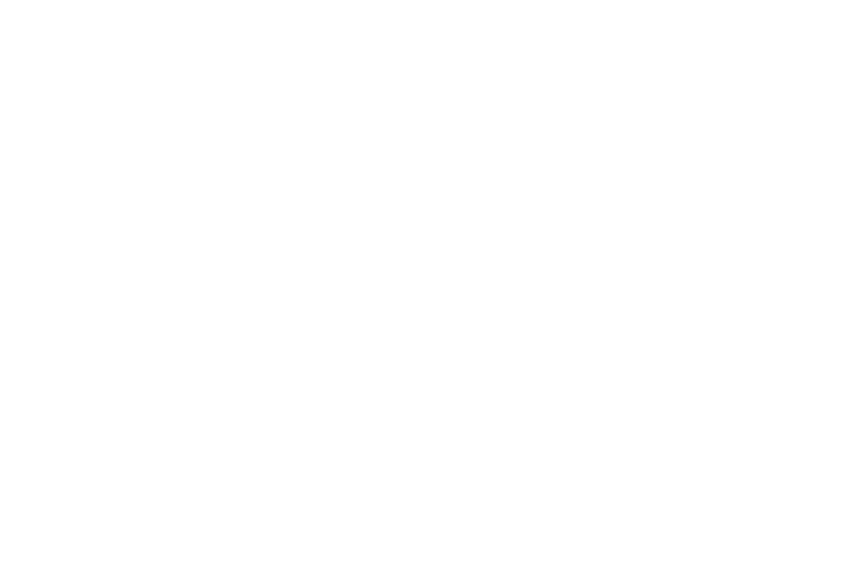

nseg = 
2
seg_tpts = 
10000
overlap = 
9760
frequency shape: (5000,)
spectra shape: (5000, 1, 4, 1)
spectra_norm shape: (5000, 1, 4, 1)
Frequency range for plotting: [0, 4999]


Text(value='', description='start:stop:step', placeholder='Regions Slicer')

Text(value='', description='f_min, f_max', placeholder='Frequency Range')

In [27]:
# For interactive plotting:
%matplotlib notebook  


from tvb.datatypes.time_series import TimeSeries
from tvb.contrib.scripts.plot.power_spectra_interactive import PowerSpectraInteractive

tsr = TimeSeries(data=source_ts[1000:, 0, inds["m1s1brl"]]._data.values, sample_period=source_ts.sample_period)
psi = PowerSpectraInteractive()
psi.time_series = tsr
psi.window_length = 1000.0
psi.show()
from ipywidgets import interact, widgets as ip_widgets
from IPython.display import display

textRegions = ip_widgets.Text(
    value='',
    placeholder='Regions Slicer',
    description='start:stop:step',
    disabled=False
)

textFreqs = ip_widgets.Text(
    value='',
    placeholder='Frequency Range',
    description='f_min, f_max',
    disabled=False
)

def callbackRegions(wdgt):
    # replace by something useful
    psi.update_regions(wdgt.value)

def callbackFreqs(wdgt):
    # replace by something useful
    psi.update_freq_range(wdgt.value)
    
textRegions.on_submit(callbackRegions)
textFreqs.on_submit(callbackFreqs)

display(textRegions)
display(textFreqs)



2021-12-08 18:18:54,758 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
2.44140625


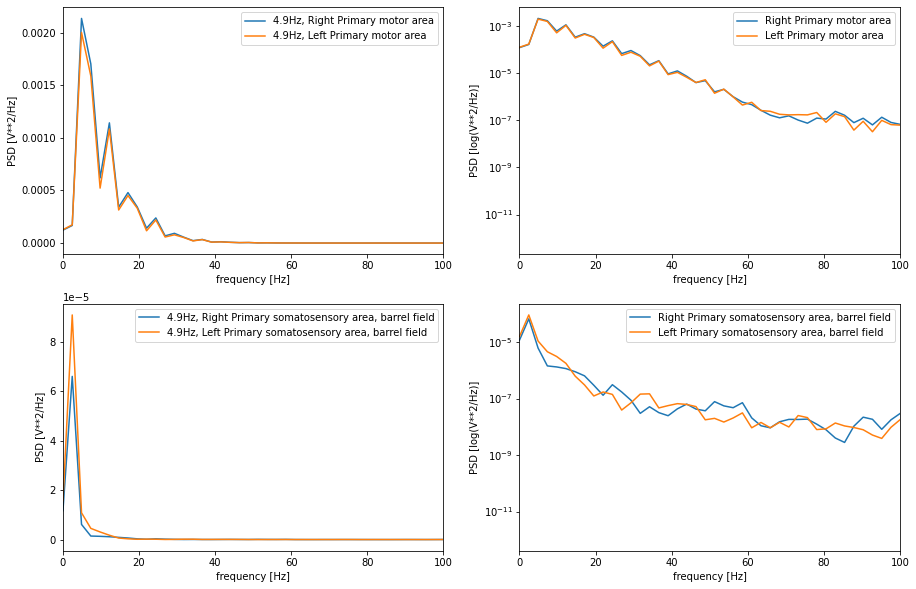

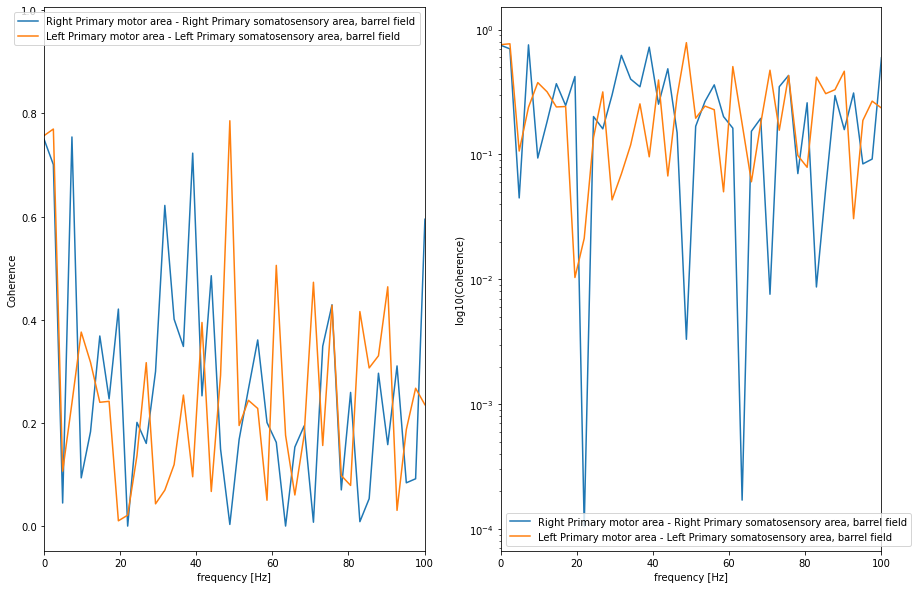

In [28]:
%matplotlib inline 

from examples.tvb_nest.notebooks.cerebellum.utils import  compute_plot_selected_spectra_coherence, compute_plot_ica

NPERSEG = np.array([256, 512, 1024, 2048, 4096])
NPERSEG = NPERSEG[np.argmin(np.abs(NPERSEG - (source_ts.shape[0]-transient/dt)))]

# Power Spectra and Coherence for M1 - S1 barrel field
compute_plot_selected_spectra_coherence(source_ts, inds["m1s1brl"], 
                                        transient=transient, nperseg=NPERSEG, fmin=0.0, fmax=100.0)

2021-12-08 18:18:56,453 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
2.44140625


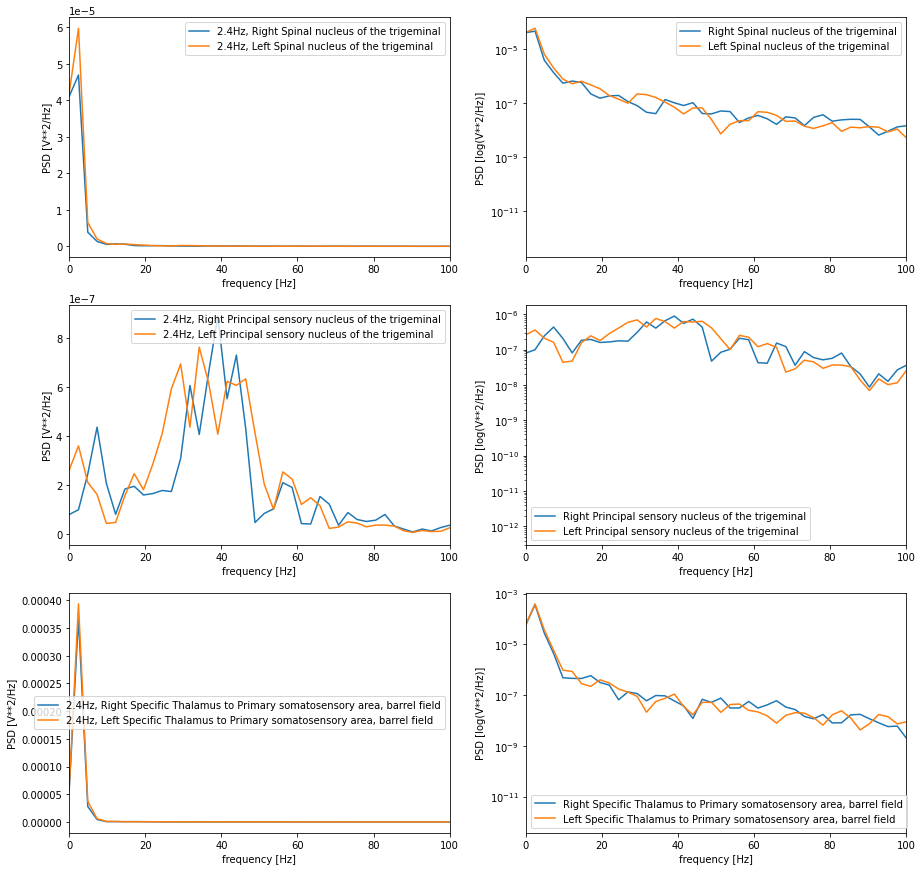

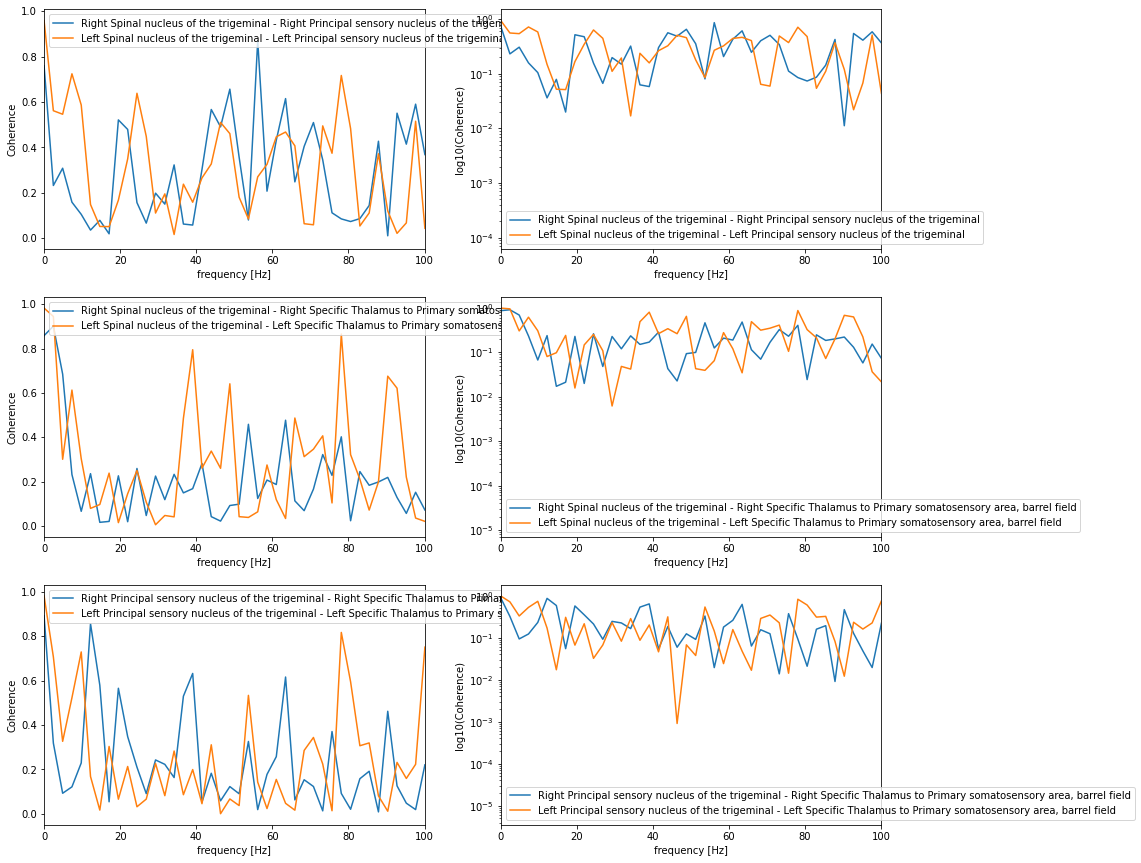

In [29]:
# Power Spectra and Coherence along the sensory pathway:
# for Medulla SPV, Sensory PONS
compute_plot_selected_spectra_coherence(source_ts, inds["sens"], 
                                        transient=transient, nperseg=NPERSEG, fmin=0.0, fmax=100.0)

/home/docker/packages/tvb-root/tvb_contrib/tvb/contrib/scripts/datatypes/time_series_xarray.py:868: MatplotlibDeprecationWarning: 
The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.
  pyplot.gcf().canvas.set_window_title(figname)


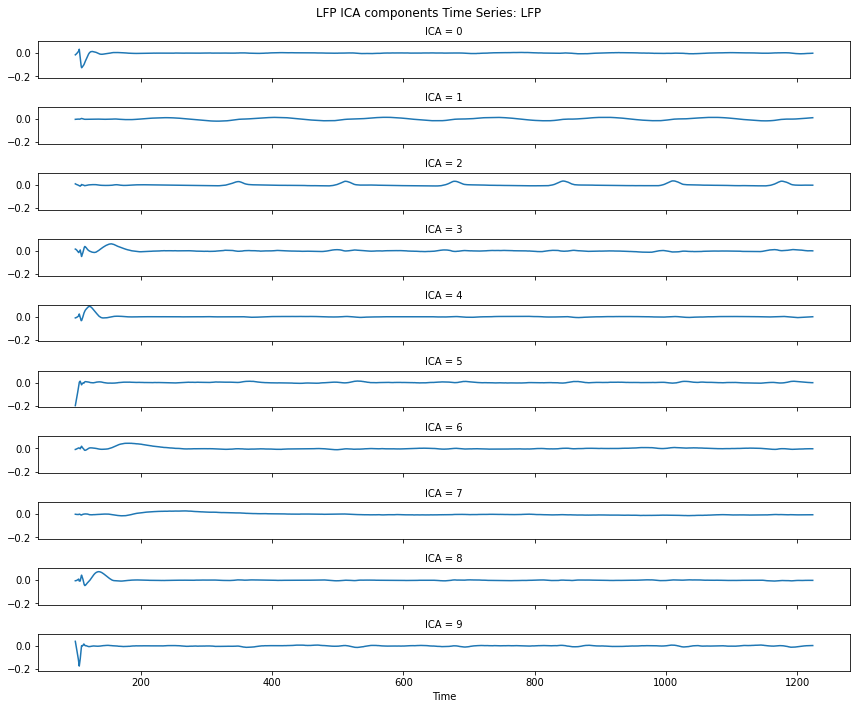

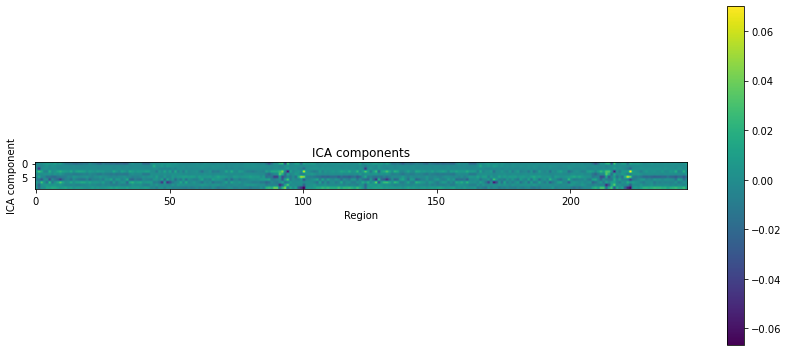

In [30]:
plotter.config.DEFAULT_SIZE = (12, 10)  # FIGSIZE
if source_ts is not None:
    # LFP (E) ICA:
    lfp_ica_comps, lfp_ics_ts, lfp_ica = compute_plot_ica(source_ts[transient:].data[:, 0, :, 0].squeeze(), 
                                                          source_ts[transient:].time,
                                                          variable="LFP", n_components=10, plotter=plotter)
    

/home/docker/env/neurosci/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:470: UserWarning: n_components is too large: it will be set to 9
  % n_components
/home/docker/packages/tvb-root/tvb_contrib/tvb/contrib/scripts/datatypes/time_series_xarray.py:868: MatplotlibDeprecationWarning: 
The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.
  pyplot.gcf().canvas.set_window_title(figname)


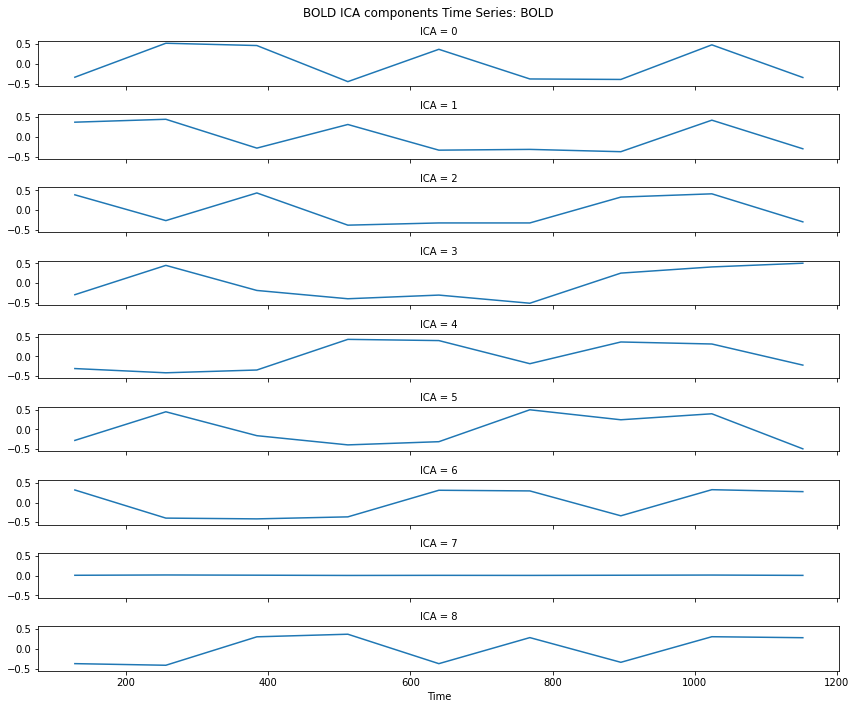

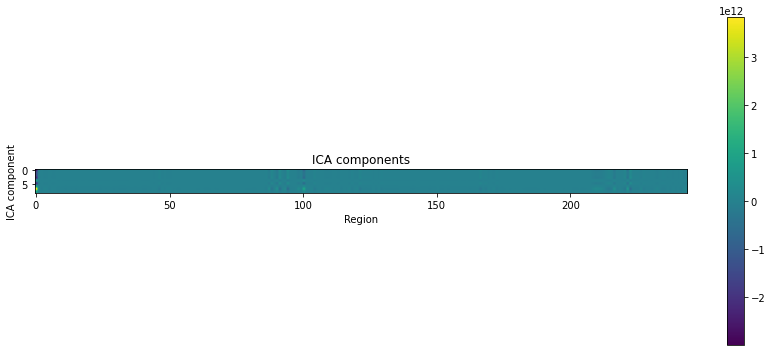

In [31]:
if bold_ts is not None:    
    # BOLD ICA:
    bold_ica_comps, bold_ics_ts, bold_ica = compute_plot_ica(bold_ts.data[:, 0, :, 0].squeeze(), bold_ts.time,
                                                             variable="BOLD", n_components=10, plotter=plotter)
    

(11240, 86)


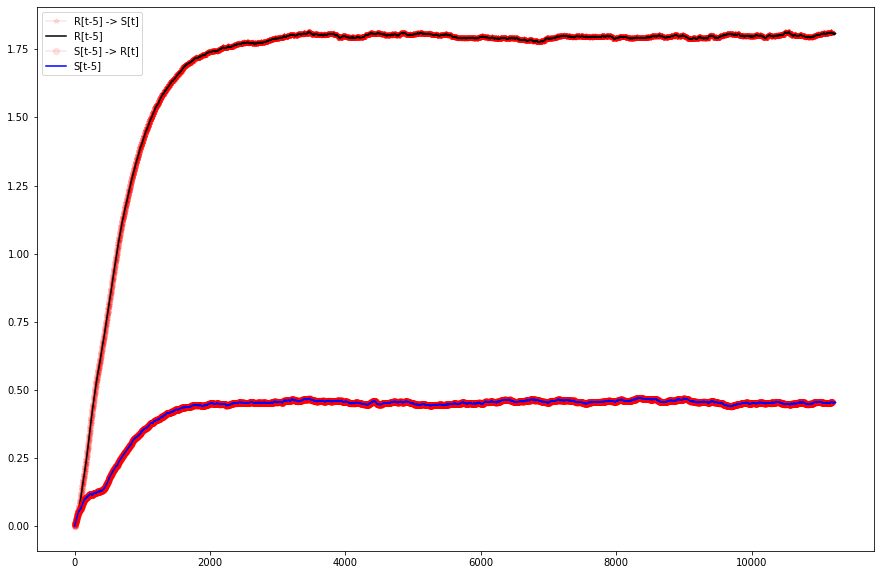

In [32]:
if TEST:
    import matplotlib.pyplot as plt 
    # Checking that internal time delays work as expected:
    RS_dels = np.concatenate(simulator.model._RS_dels, -1).T
    SR_dels = np.concatenate(simulator.model._SR_dels, -1).T
    print(RS_dels.shape)
    plt.figure(figsize=(15, 10))
    plt.plot(RS_dels[51:, 0], 'r-*', label='R[t-5] -> S[t]', alpha=.1)
    plt.plot(source_ts.data[:, 1, inds["thalspec"][0], 0], 'k', label='R[t-5]')
    plt.plot(SR_dels[51:, 0], 'r-o', label='S[t-5] -> R[t]', alpha=.1)
    plt.plot(source_ts.data[:, 0, inds["thalspec"][0], 0], 'b', label='S[t-5]')
    plt.legend()

2021-12-08 18:19:04,249 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
2021-12-08 18:19:04,275 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
2021-12-08 18:19:04,306 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
2021-12-08 18:19:04,344 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
2021-12-08 18:19:04,380 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
2021-12-08 18:19:04,434 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
2021-12-08 18:19:04,477 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries lab

<IPython.core.display.Javascript object>


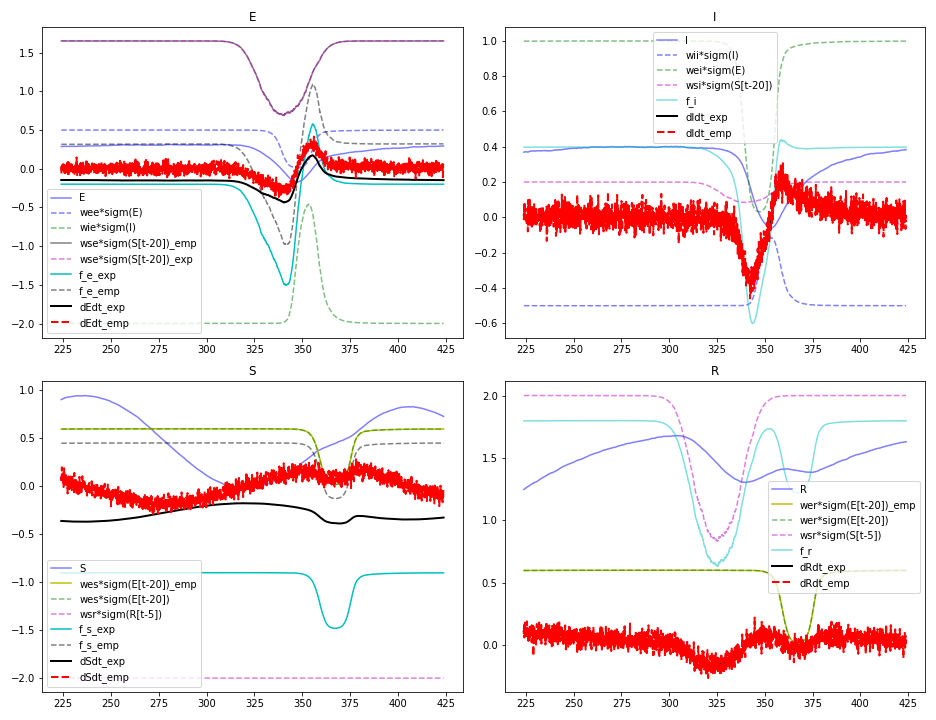

In [33]:
%matplotlib notebook

def test(source_ts, inds, cth=None, Io=0.0, transient=10000, ET=[], SC=[],
         wee=1.4 if DEMO else 0.5, 
         wei = 1.4 if DEMO else 1.0, 
         wie = -3. if DEMO else -2.0, 
         wii = -0.5, # wie = -2.,wii = -0.5,
         wertn = 0.6,
         weth =  0.6,
         wthe = 1.65, # 1.65,
         wthi = 0.2,
         wrtnth = -2.,
         wthrtn = 2.,
         # a_e = 0.3,a_i = 0.5,a_th = 0.2,a_rtn = 0.2:
         a_e = 0.9 if DEMO else 0.3,  
         a_i = 0.9 if DEMO else 0.5, 
         a_th=0.25 if DEMO else 0.2, 
         a_rtn=0.25 if DEMO else 0.2, 
         i_e = -0.35,
         i_i = -0.3,
         i_th = 0.5,
         i_rtn = -0.8
        ):
    
    # Neuronal response function
    def f(u,gain=20.0,threshold=0.0):
        output= 1./(1.+np.exp(-gain*(u-threshold))); 
        return output 
    
    mind = inds["m1s1brl"][0]
    thind = inds["motor"][0]
    e = source_ts[-transient:-transient+2000, [0], mind].data.squeeze()
    i = source_ts[-transient:-transient+2000, [1], mind].data.squeeze()
    fe2 = source_ts[-transient:-transient+2000, [2], mind].data.squeeze()
    s = source_ts[-transient:-transient+2000, [0], thind].data.squeeze()
    r = source_ts[-transient:-transient+2000, [1], thind].data.squeeze()
    fs2 = source_ts[-transient:-transient+2000, [2], thind].data.squeeze()
    t = source_ts[-transient:-transient+2000, [0], mind].time
    e_sigm = f(e)
    i_sigm = f(i)
    # Delayed s by tau_ct = 20
    sd_ct = source_ts[-transient-200:-transient+2000-200, [0], thind].data.squeeze()
    sd_ct_sigm = f(sd_ct)
        
    # Delayed e by tau_ct = 20
    ed = source_ts[-transient-200:-transient+2000-200, [0], mind].data.squeeze()
    ed_sigm = f(ed)
    # Delayed s by tau_tt = 5
    sd_tt = source_ts[-transient-50:-transient+2000-50, [0], thind].data.squeeze()
    sd_tt_sigm = f(sd_tt)
    # Delayed r by tau_tt = 5
    rd_tt = source_ts[-transient-50:-transient+2000-50, [1], thind].data.squeeze()
    rd_tt_sigm = f(rd_tt)
    
    fig, axes = plt.subplots(2, 2, figsize=(13, 10))
    alpha = 0.5
    lw = 2.0
    
    # dedt:
    ee = wee*e_sigm # 1.4
    ie = wie*i_sigm # -3.0
    se = wthe*sd_ct_sigm  # 1.65
    fe = ee + ie + se + i_e
    dedt = a_e*(-e + fe) 
    dedt2 = np.diff(e) / 0.1 / 0.1 
    axes[0, 0].plot(t, e, "b", label="E", alpha=alpha)
    axes[0, 0].plot(t, ee, "b--", label="wee*sigm(E)", alpha=alpha)
    axes[0, 0].plot(t, ie, "g--", label="wie*sigm(I)", alpha=alpha)
    if len(SC):
        se2 = wthe*SC[-transient:-transient+2000, 1]
        axes[0, 0].plot(t, se2, "k", label="wse*sigm(S[t-20])_emp", alpha=alpha)
    axes[0, 0].plot(t, se, "m--", label="wse*sigm(S[t-20])_exp", alpha=alpha)
    axes[0, 0].plot(t, fe, "c", label="f_e_exp")  # , alpha=alpha
    axes[0, 0].plot(t, fe2, "k--", label="f_e_emp", alpha=alpha) # 
    axes[0, 0].plot(t, dedt, "k", label="dEdt_exp", linewidth=lw)
    axes[0, 0].plot(t[:-1], dedt2, 'r--', label="dEdt_emp", linewidth=lw)
    axes[0, 0].legend()
    axes[0, 0].set_title("E")
    
    # didt:
    ie = wei*e_sigm # 1.4
    ii = wii*i_sigm # -0.5
    si = wthi * sd_ct_sigm  # 0.2
    fi = ie + ii + si + i_i
    didt = a_i*(-i + fi) 
    didt2 = np.diff(i) / 0.1 / 0.1 
    axes[0, 1].plot(t, i, "b", label="I", alpha=alpha)
    axes[0, 1].plot(t, ii, "b--", label="wii*sigm(I)", alpha=alpha)
    axes[0, 1].plot(t, ie, "g--", label="wei*sigm(E)", alpha=alpha)
    axes[0, 1].plot(t, si, "m--", label="wsi*sigm(S[t-20])", alpha=alpha)
    axes[0, 1].plot(t, fi, "c", label="f_i", alpha=alpha)
    axes[0, 1].plot(t, didt, "k", label="dIdt_exp", linewidth=lw)
    axes[0, 1].plot(t[:-1], didt2, 'r--', label="dIdt_emp", linewidth=lw)
    axes[0, 1].legend()
    axes[0, 1].set_title("I")
    
    # dsdt:
    es = weth * ed_sigm
    rs = wrtnth * rd_tt_sigm
    fs = es + rs + i_th + Io
    dsdt = a_th*(-s + fs)
    dsdt2 = np.diff(s) / 0.1 / 0.1
    axes[1, 0].plot(t, s, "b", label="S", alpha=alpha)
    if len(ET):
        es2 = weth*ET[-transient:-transient+2000, 1].squeeze()
    axes[1, 0].plot(t, es2, "y", label="wes*sigm(E[t-20])_emp")
    axes[1, 0].plot(t, es, "g--", label="wes*sigm(E[t-20])", alpha=alpha)
    axes[1, 0].plot(t, rs, "m--", label="wsr*sigm(R[t-5])", alpha=alpha)
    axes[1, 0].plot(t, fs, "c", label="f_s_exp")  # , alpha=alpha
    axes[1, 0].plot(t, fs2, "k--", label="f_s_emp", alpha=alpha)  # 
    axes[1, 0].plot(t, dsdt, "k", label="dSdt_exp", linewidth=lw)
    axes[1, 0].plot(t[:-1], dsdt2, 'r--', label="dSdt_emp", linewidth=lw)
    axes[1, 0].legend()
    axes[1, 0].set_title("S")
    
    # drdt:
    er = wertn * ed_sigm
    sr = wthrtn * sd_tt_sigm
    fr = er + sr + i_rtn
    drdt = a_rtn*(-r + fr) 
    drdt2 = np.diff(r) / 0.1 / 0.1 
    axes[1, 1].plot(t, r, "b", label="R", alpha=alpha)
    if len(ET):
        er2 = wertn*ET[-transient:-transient+2000, 1].squeeze()
    axes[1, 1].plot(t, er2, "y", label="wer*sigm(E[t-20])_emp")
    axes[1, 1].plot(t, er, "g--", label="wer*sigm(E[t-20])", alpha=alpha)
    axes[1, 1].plot(t, sr, "m--", label="wsr*sigm(S[t-5])", alpha=alpha)
    axes[1, 1].plot(t, fr, "c", label="f_r", alpha=alpha)
    axes[1, 1].plot(t, drdt, "k", label="dRdt_exp", linewidth=lw)
    axes[1, 1].plot(t[:-1], drdt2, 'r--', label="dRdt_emp", linewidth=lw)
    axes[1, 1].legend()
    axes[1, 1].set_title("R")
    
    fig.tight_layout()

if TEST:    
    test(source_ts, inds, Io=simulator.model.I_o[0].item(), 
         ET=np.array(simulator.model._cET).squeeze(),
         SC=np.array(simulator.model._cSC).squeeze()
        )


# References

1 Sanz Leon P, Knock SA , Woodman MM, Domide L, <br>
  Mersmann J, McIntosh AR, Jirsa VK. 2013. <br>
  The Virtual Brain: a simulator of primate brain network dynamics. <br>
  Frontiers in Neuroinformatics (7:10. doi: 10.3389/fninf.2013.00010) <br>
  https://www.thevirtualbrain.org/tvb/zwei <br>
  https://github.com/the-virtual-brain <br>

2 Ritter P, Schirner M, McIntosh AR, Jirsa VK. 2013.  <br>
  The Virtual Brain integrates computational modeling and multimodal neuroimaging. <br>
  Brain Connectivity 3:121–145. <br>

3 Griffiths JD, McIntosh AR, Lefebvre J. 2020.   <br>
  A Connectome-Based, Corticothalamic Model of State- <br>
  and Stimulation-Dependent Modulation of Rhythmic Neural Activity and Connectivity <br>
  Frontiers in Computational Neuroscience (vol. 14. doi: 10.3389/fncom.2020.575143) <br>
  https://www.frontiersin.org/articles/10.3389/fncom.2020.575143/full#h12
  
4 Jordan, Jakob; Mørk, Håkon; Vennemo, Stine Brekke;   Terhorst, Dennis; Peyser, <br>
  Alexander; Ippen, Tammo; Deepu, Rajalekshmi;   Eppler, Jochen Martin; <br>
  van Meegen, Alexander;   Kunkel, Susanne; Sinha, Ankur; Fardet, Tanguy; Diaz, <br>
  Sandra; Morrison, Abigail; Schenck, Wolfram; Dahmen, David;   Pronold, Jari; <br>
  Stapmanns, Jonas;   Trensch, Guido; Spreizer, Sebastian;   Mitchell, Jessica; <br>
  Graber, Steffen; Senk, Johanna; Linssen, Charl; Hahne, Jan; Serenko, Alexey; <br>
  Naoumenko, Daniel; Thomson, Eric;   Kitayama, Itaru; Berns, Sebastian;   <br>
  Plesser, Hans Ekkehard <br>
  NEST is a simulator for spiking neural network models that focuses <br>
  on the dynamics, size and structure of neural systems rather than on <br>
  the exact morphology of individual neurons. <br>
  For further information, visit http://www.nest-simulator.org. <br>
  The release notes for this release are available at  <br>
  https://github.com/nest/nest-simulator/releases/tag/v2.18.0 <br>